## The plan

Now that all the midi's are confirmed, it is time to put it into a prediction model and to make an own jazz song/melody<br><br>
I will try to make a new predicted jazz melody with the RNN-LSTM model, together with Keras (library), TensorFlow (library), Music21 (library) and MuseScore (program).<br>
<hr>

I will be working with RNN-LSTM because I am going to focus on the melodies of the songs, and RNN-LSTM is great with working with melodies, because melodies have long-term structural patterns, and LSTM captures "long-term temporal dependencies".<br>
So the model is a perfect match with what I plan to do<br><br>

The model works like this:<br>
I give the model the notes, rests and durations of the songs. The LSTM will process this and it will give me the next predicted note in the melody (by looking at all the inserted data). It basically puts that predicted note at the end of the insert at the beginning. The notes, rests and durations + the extra predicted note at the end will undergo the LSTM again. This also again gives a new note at the end. And so the process repeats and repeats, how many times I ask of it.<br>
>So: notes, rests, durations -> LSTM model -> predicted next note in melody (repeat)



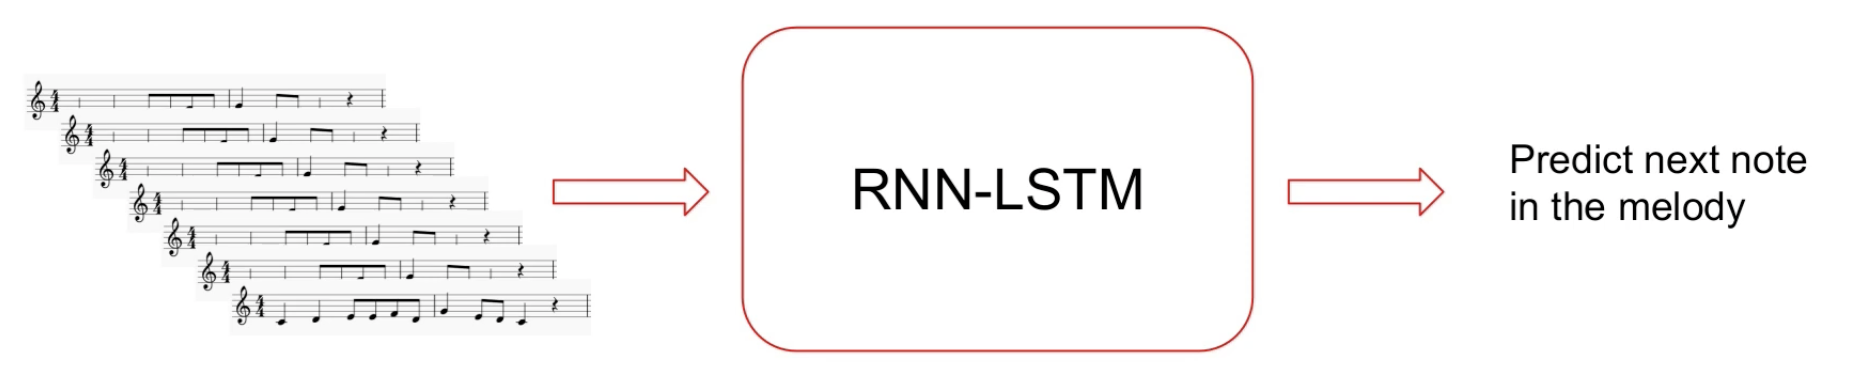

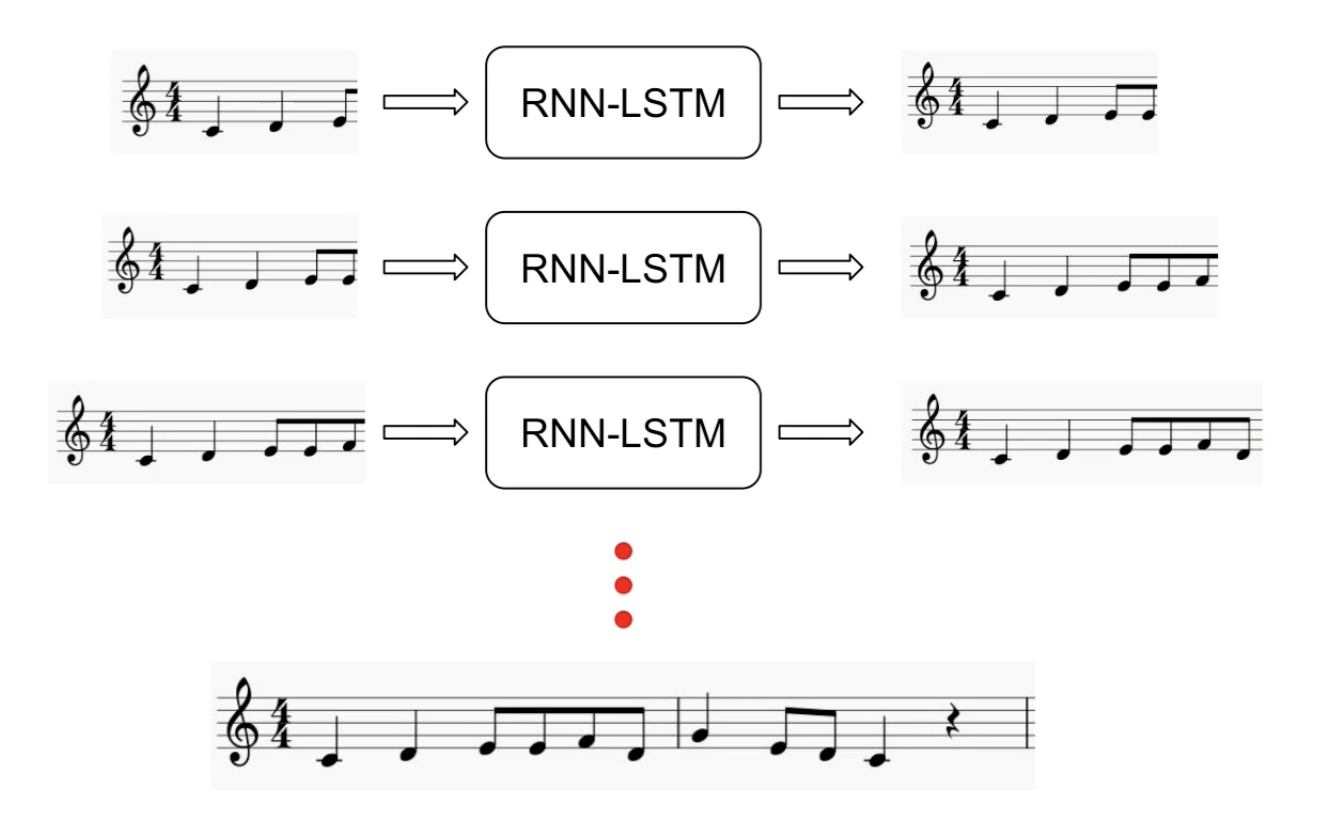

As can be seen in the picture, when repeating the process a new predicted melody will be born<br>
<i>Source images, a video with explanation about the model: https://www.youtube.com/watch?v=FLr0r-QhqH0</i><br>

To give a summary, this is going to happen in multiple steps:
<ol>
    <li>I am going to look at the notes, rests and durations of the midi songs.</li>
    <li>I am going to preprocess them in a neat coherent json file</li>
    <li>I am going to put it into the LSTM model and let it process</li>
<li>I am going to receive the results from that model and evaluate it</li>
    
</ol>
<i>Further explanation will be given when arriving at the code</i>

<hr>

## Building of the model

First the midi's need to be imported to this notebook

In [1]:
# glob helps returning all file paths that match a specific pattern
import glob 
# music21 is a toolkit for computer-aided music
import music21 as m21
from music21 import converter, instrument, note, chord

songs = []

# access the .mid files in the folder midi_songs
for file in glob.glob("midi_songs/*.mid"):
    
    # put all the .mid songs in the empty list 'songs'
    song = converter.parse(file)
    songs.append(song)
    print(file)
    
# source:
# as done by the Generative Deep Learning book example

midi_songs/HankMobley_SoulStation_FINAL.mid
midi_songs/JohnColtrane_BodyAndSoul_FINAL.mid
midi_songs/SonnyRollins_VierdBlues_FINAL.mid
midi_songs/MichaelBrecker_IMeanYou_FINAL.mid
midi_songs/JoeLovano_BodyAndSoul-2_FINAL.mid
midi_songs/WayneShorter_InfantEyes_FINAL.mid
midi_songs/DonByas_CognacBlues_FINAL.mid
midi_songs/MichaelBrecker_SongForBilbao_FINAL.mid
midi_songs/LesterYoung_BodyAndSoul_FINAL.mid
midi_songs/WayneShorter_DownUnder_FINAL.mid
midi_songs/WayneShorter_SpeakNoEvil_FINAL.mid
midi_songs/MichaelBrecker_NeverAlone_FINAL.mid
midi_songs/StanGetz_BodyAndSoul_FINAL.mid
midi_songs/MichaelBrecker_MidnightVoyage_FINAL.mid
midi_songs/DonByas_HarvardBlues-1_FINAL.mid
midi_songs/ChuBerry_BodyAndSoul-2_FINAL.mid
midi_songs/HankMobley_Doodlin'_FINAL.mid
midi_songs/ZootSims_NightAndDay-2_FINAL.mid
midi_songs/ZootSims_AllTheThingsYouAre_FINAL.mid
midi_songs/BobBerg_SecondSight_FINAL.mid
midi_songs/ColemanHawkins_BodyAndSoul_FINAL.mid
midi_songs/StanGetz_I'mGladThereIsYou_FINAL.mid
midi_

In [2]:
# Checking how many songs I will be working with

print("Number of songs:", (len(songs)))

Number of songs: 113


As can be seen, there are a total of 113 songs. I ended the Notebook with 128 songs, but unfortunately I had to scrap 15, because they gave the weirdest errors, that even the Internet didn't know, when preprocessing and I decided to remove them.

But, after succesfully having implemented the midi songs, let's take a look at the first of them.

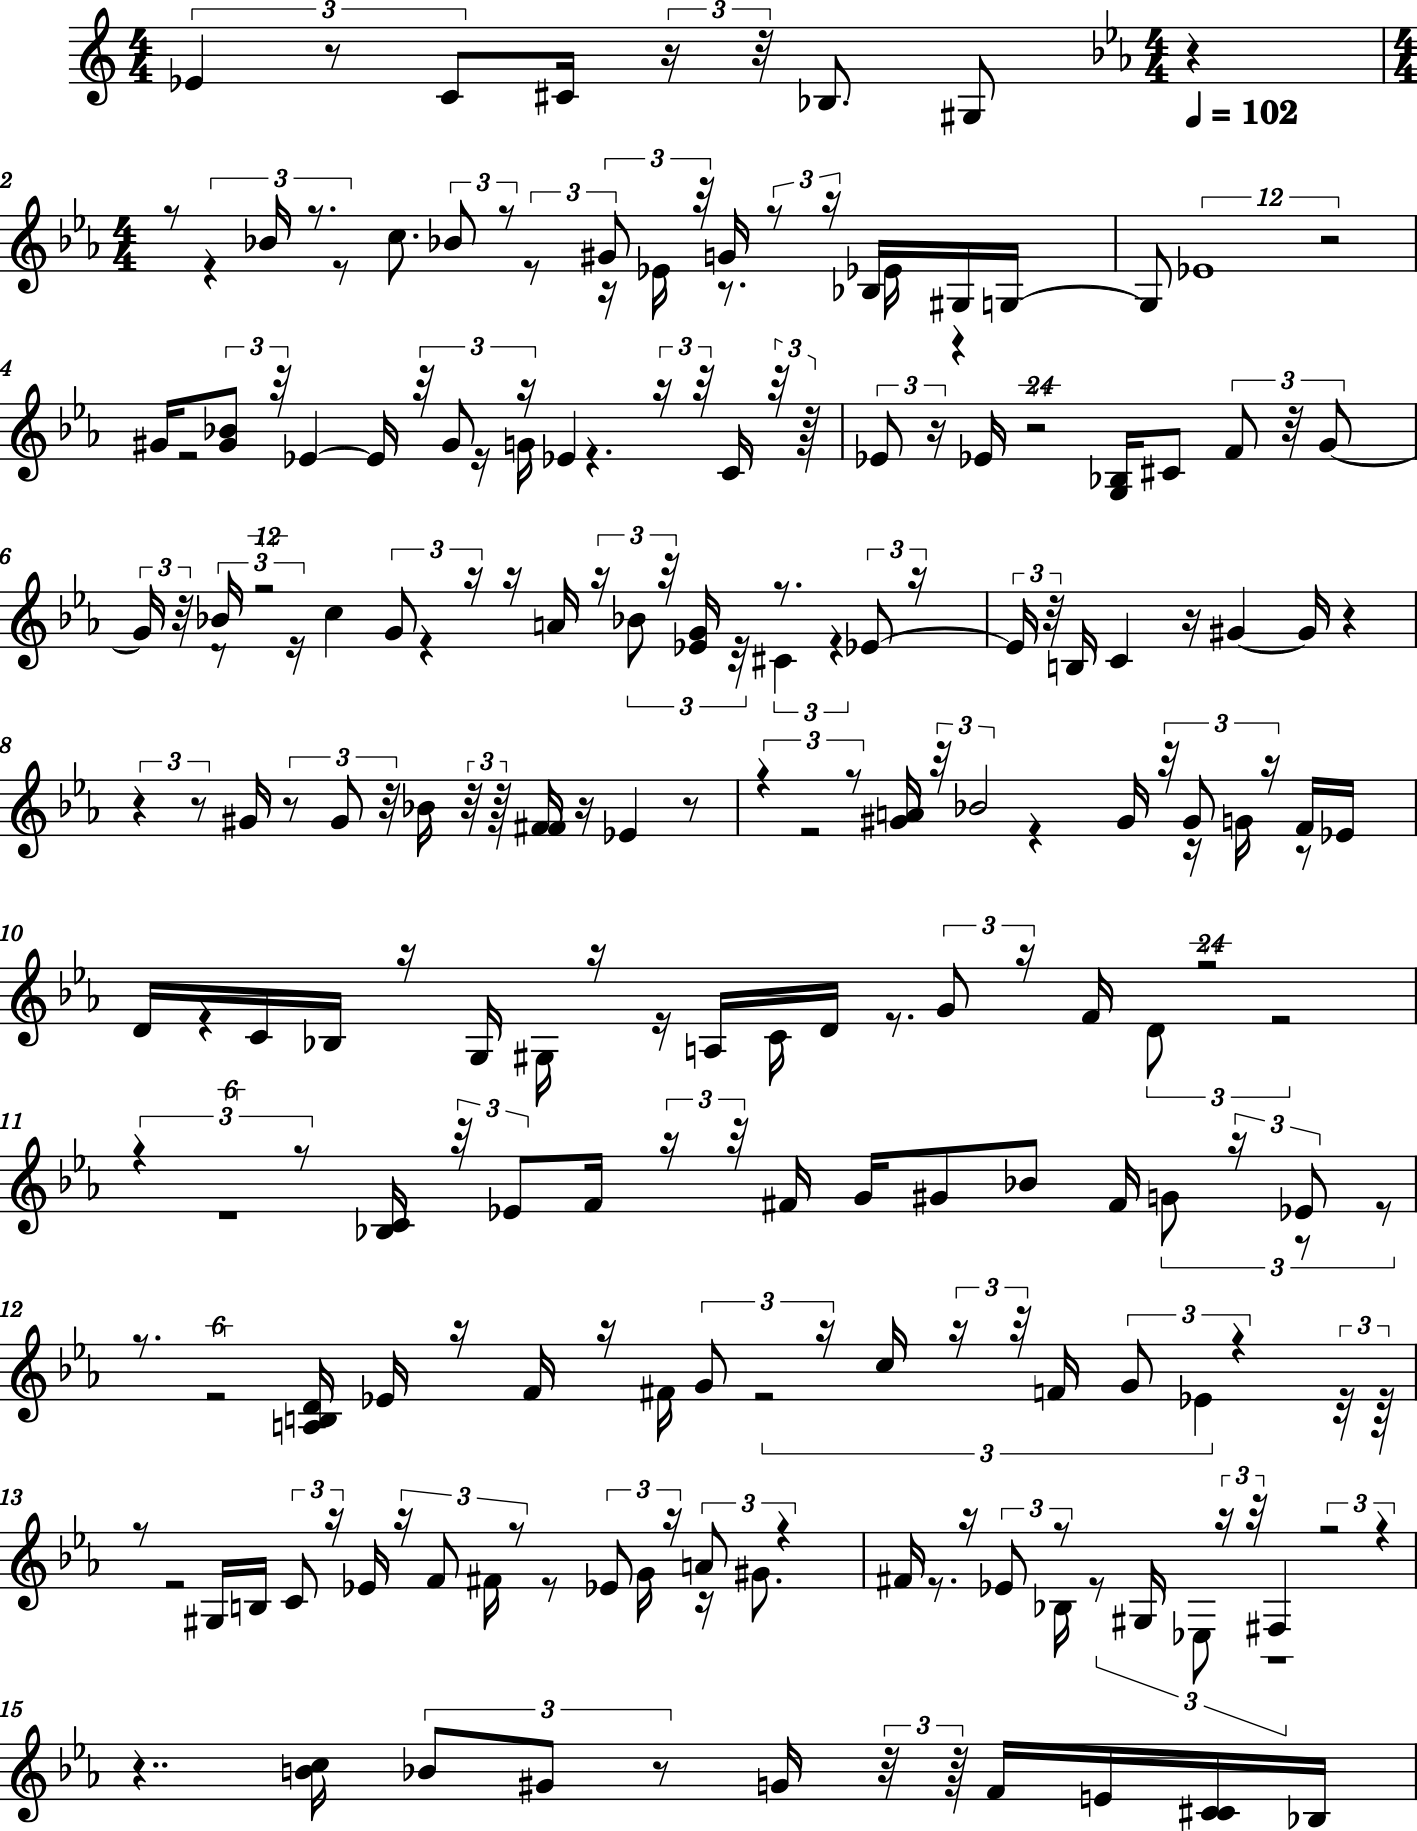

In [3]:
song = songs[0]

# Able to show with the help of MuseScore the program
song.show()

When looking at the music sheet, it can be seen that it is not the easiest of notes and spaces.<br>
It can also observed that there is a lot of variety in these notes and durations.<br><br>
In the next step, let's look at these notes and durations, because those are the main components of what a melody is made of and thereby also the main components needed for the LSTM model.

In [4]:
# empty list where I will be collecting them
notes = []
durations = []

# going through every space ("element") in the song from above.
for element in song.flat:
    
    # isinstace() checks whether the variable if a specific data type, in this case note
    # if element is a note, then put the note in the list and check the duration for it and put that also away
    
    # this is for more difficult notes, like G#4.G4
    if isinstance(element, m21.chord.Chord):
        notes.append('.'.join(n.nameWithOctave for n in element.pitches))
        durations.append(element.duration.quarterLength)    
        
    # this is for the more recognisable notes, like G4
    if isinstance(element, m21.note.Note):
        if element.isRest:
            notes.append(str(element.name))
            durations.append(element.duration.quarterLength)
        else:
            notes.append(str(element.nameWithOctave))
            durations.append(element.duration.quarterLength)
            
# source:
# https://www.youtube.com/watch?v=FLr0r-QhqH0&list=PL-wATfeyAMNr0KMutwtbeDCmpwvtul-Xz
# https://github.com/alexissa32/DataScienceMusic/blob/master/1LSTMAtt1LSTMLayer-fulldataset-results/.ipynb_checkpoints/DataScienceMusic-checkpoint.ipynb

In [5]:
# let's look at all the collected notes and durations from the music sheet from above

print(notes)
print(durations)

['E-4', 'C4', 'C#4', 'B-3', 'G#3', 'B-4', 'C5', 'B-4', 'E-4', 'G#4', 'G4', 'E-4', 'B-3', 'G#3', 'G3', 'G3', 'E-4', 'G#4', 'B-4.G#4', 'E-4', 'G#4', 'G4', 'E-4', 'C4', 'E-4', 'E-4', 'G3.B-3', 'C#4', 'F4', 'G4', 'G4', 'B-4', 'C5', 'G4', 'A4', 'B-4', 'G4.E-4', 'C#4', 'E-4', 'E-4', 'B3', 'C4', 'G#4', 'G#4', 'G#4', 'B-4', 'F#4.F4', 'E-4', 'A4.G#4', 'B-4', 'G#4', 'G#4', 'G4', 'F4', 'E-4', 'D4', 'C4', 'B-3', 'G3', 'G#3', 'A3', 'C4', 'D4', 'G4', 'F4', 'D4', 'C4.B-3', 'E-4', 'F4', 'F#4', 'G4', 'G#4', 'B-4', 'F#4', 'G4', 'E-4', 'A3.B3.D4', 'E-4', 'F4', 'F#4', 'G4', 'C5', 'F4', 'G4', 'E-4', 'G#3', 'B3', 'C4', 'E-4', 'F4', 'F#4', 'E-4', 'G4', 'A4', 'G#4', 'F#4', 'E-4', 'B-3', 'G#3', 'E-3', 'F#3', 'C5.B4', 'B-4', 'G#4', 'G4', 'F4', 'E4', 'C#4.C4', 'B-3', 'A3', 'C4', 'E-4', 'G4', 'G#3', 'G4', 'G#4.G4', 'F4', 'D4', 'B3', 'B-3', 'E-4', 'E-4', 'B-3', 'G#3', 'E-4', 'A3', 'E-4', 'B-3', 'E-4', 'E-4', 'E-4', 'G4', 'G#4', 'G4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'G#4', 'B-4', 'G#4.F#4', 'E-4', 'E-4', 'E-4', 

That is a lot of data for only one song. The Fraction/durations seems to be around the same, but let's visualize the notes for for more clarification

In [6]:
import pandas as pd

df = pd.DataFrame(notes)

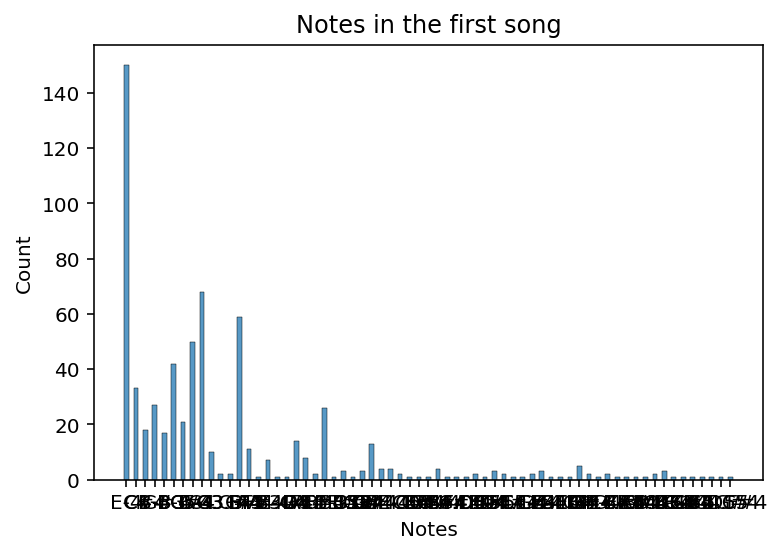

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.histplot(df[0].dropna(), kde=False, shrink=.5) 
plt.title('Notes in the first song')
plt.xlabel('Notes')
plt.ylabel('Count')
plt.show()

Conclusion: jazz songs have a lot of different notes, they aren't even readable in the plot<br><br>

Now that the notes and durations have been looked at, it is clear that it is not workable for a machine. The notes and durations need to be encoded so that the model can better process it, and then collect it. Because the list now, with ['E-4', 'C4', 'C#4' ...] and [Fraction(2, 3) 0.25...], can't go through the LSTM, it is still to difficult.<br><br>
So what I want to do now is make the notes and durations go together into one new list. Both the notes ('E-4') and the durations ('0.25') also need to be simplified so that the new list is completely understandable. So basically, convert the data into a coded form

In [8]:
# for time step I picked the smallest duration, that of 0.25. So the function will go through every 0.25 duration
# and look at what is presented at that duration space.
def encode_song(song, time_step=0.25):

    encoded_song = []

    for event in song.flat.notesAndRests:

        # transforming of the notes into a number instead of ('E-4')
        if isinstance(event, m21.note.Note):
            symbol = event.pitch.midi # example: E-4 to 63
        # if a note is lingering, put a 'r' as in rest in the place. ("lingering: long press of note")
        elif isinstance(event, m21.note.Rest):
            symbol = "r"

        # converting the note and rest into time series notation
        steps = int(event.duration.quarterLength / time_step)
        for step in range(steps):

            # if a note or rest is present, then encode it. If nothing is present in the 0.25 duration slot, 
            # then it means nothing is being played, then let's put a "_" there
            if step == 0:
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")

    # cast encoded song to one big string
    encoded_song = " ".join(map(str, encoded_song))

    # return so it can be looked at
    return encoded_song

# source:
# https://www.youtube.com/watch?v=FLr0r-QhqH0&list=PL-wATfeyAMNr0KMutwtbeDCmpwvtul-Xz

In [9]:
# activitating the function
# looking at the encoding of the first song
encode_song(song, time_step=0.25)

'63 _ r 60 61 58 _ _ 56 _ r _ _ _ r _ r _ 70 72 _ _ r _ _ r 70 63 r r _ _ 68 67 63 r r _ _ _ 58 56 55 55 _ 63 _ _ _ _ _ _ _ _ r _ _ _ 68 r _ _ _ _ _ _ _ _ r 63 _ _ _ _ 68 67 63 _ _ _ r _ _ _ _ _ 60 63 63 r _ _ _ _ _ _ r 61 _ 65 67 r 70 72 _ _ _ r _ _ _ r _ _ _ 67 r 69 70 r 61 _ r _ _ r _ 63 59 60 _ _ _ r 68 _ _ _ _ r _ _ _ r _ 68 r 68 70 r r 63 _ _ _ r _ r _ r _ _ _ _ _ _ _ _ _ _ _ _ r 70 _ _ _ _ _ 68 68 67 65 r _ 63 62 r _ _ _ 60 58 r 55 56 r r 57 60 62 r _ _ 67 65 62 r _ _ _ _ r _ _ _ r _ r _ _ _ _ _ _ _ _ _ _ _ _ r 63 65 66 67 68 _ 70 _ 66 67 63 r r _ _ r _ _ _ _ _ r 63 r 65 66 r r _ _ _ _ 67 72 65 67 63 _ r _ r _ r _ _ _ _ _ _ _ 56 59 60 63 65 66 r r _ 63 67 69 r 68 _ _ r _ 66 r _ _ r 63 58 r r 56 51 54 _ _ _ r _ _ _ _ _ _ _ _ r _ _ _ _ r _ _ _ _ _ _ r 70 68 67 65 64 64 58 r r _ 57 60 63 r _ r _ _ _ _ _ _ 67 _ _ _ 56 67 67 r r _ 65 62 59 r r 58 63 r 63 _ _ 58 56 63 r 57 _ 63 r 58 r _ _ _ _ _ _ _ _ _ _ _ _ _ 63 _ _ r _ _ _ _ 63 r 63 67 68 67 r 63 r _ _ _ _ _ _ _ _ _ _ _ _ _ r 63 _ 6

It can be seen that the notes now have been encoded to numbers(symbols), and durations have been transformed to r and _ (symbols). R indicated a rest, and _ indicates that a note has been held. Also, the notes and durations are now combined, so the song is a lot more readable for a machine.<br><br>

To give an example of what has happened, the first row of notes from above was:<br><br>
<i>['E-4', 'C4', 'C#4', 'B-3', 'G#3', 'B-4', 'C5', 'B-4', 'E-4', 'G#4', 'G4', 'E-4', 'B-3', 'G#3', 'G3', 'G3', 'E-4']</i><br><br> There are a total of four 'E-4' in this row, let's look at the encoded version from the same first row:<br><br><i>'63 _ r 60 61 58 _ _ 56 _ r _ _ _ r _ r _ 70 72 _ _ r _ _ r 70 63 r r _ _ 68 67 63 r r _ _ _ 58 56 55 55 _ 63 _ _ _' </i><br>

The note 'E-4' has gotten the number 63. As the number 63 is also four times present in the second row and also present on right spots.

<br>A whole song was succesfully encoded, but there are a total of 113 songs, so this process needs to repeat 112 times<br>
This can be done by repeating the functions from above for each song, so a for loop needs to be made that goes through the songs list that was made in the beginning

In [10]:
# os is a module that helps with interacting with the operating system
import os

# preprocess every midi that is found in midi_songs
def preprocess(dataset_path):

    # enumerate is for when you need a count and a value
    for i, song in enumerate(songs):

        # the function from above that encodes
        encoded_song = encode_song(song)

        # save each song to a text file, in a new "dataset" folder
        save_path = os.path.join("dataset", str(i))
        with open(save_path, "w") as fp:
            fp.write(encoded_song)

In [11]:
# activating the function
preprocess("midi_songs/*.mid")

What happened now is that each song, all 113, have been encoded and put into a folder, as can been seen below

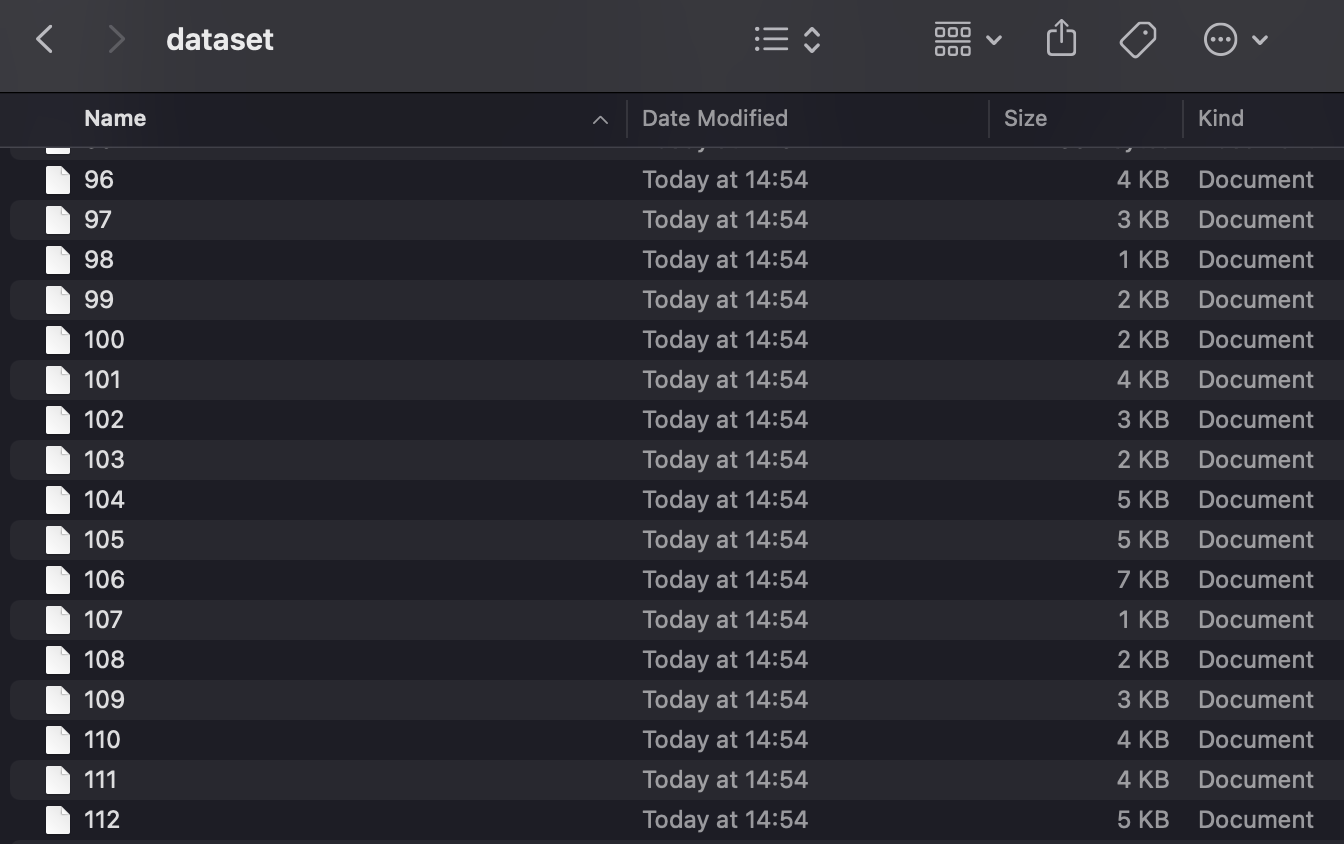

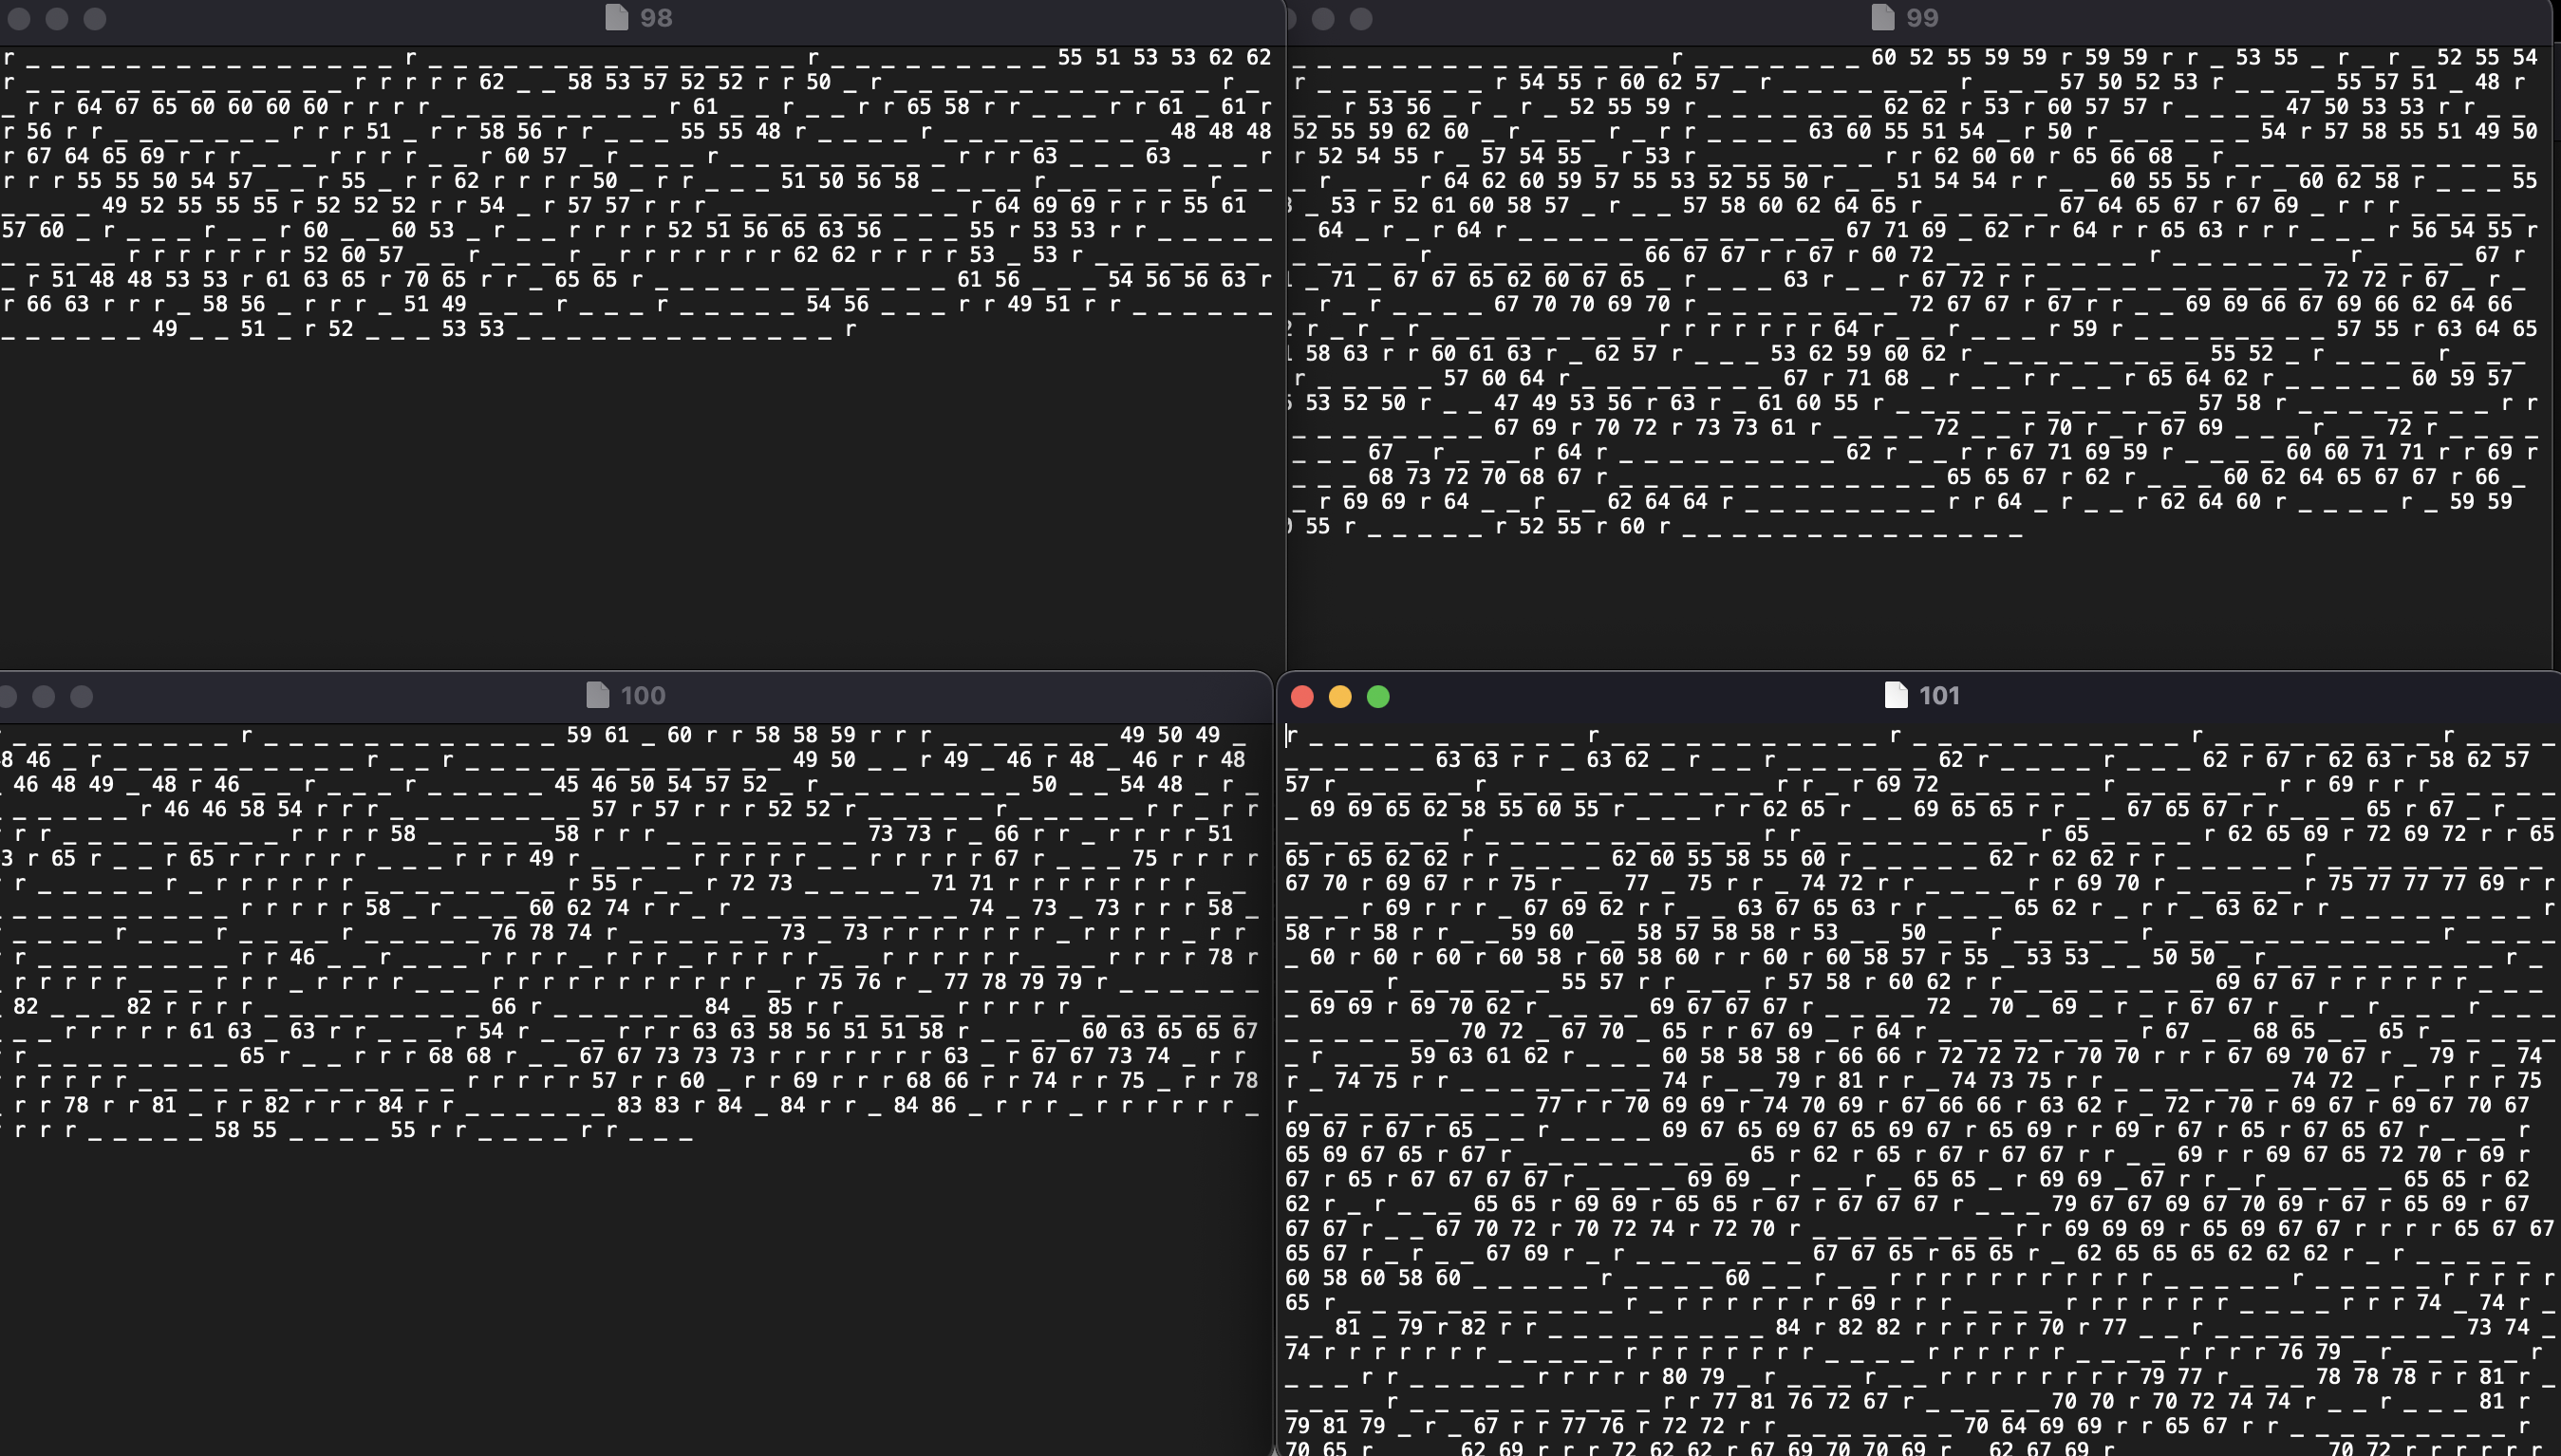

The preprocessing part is now almost done

In [12]:
# a small function to load the songs for the next function

def load(file_path):
    
    with open(file_path, "r", encoding='windows-1252') as fp:
        
        song = fp.read()
        
    return song

# error was saved thanks to: https://github.com/Currie32/Spell-Checker/issues/14

The next step is to put all those single files with encoded song together into one big file. I do this because before the LSTM model can work, sequencies need to be made. And it is easier to take one file to create sequencies than to have to look into each one

In [13]:
# sequence length refers to the space between the encoded songs
sequence_length = 64

def create_single_file_dataset(dataset_path, file_dataset_path, sequence_length):
    
    # I want to use 64 items. So, I will make a song delimiter. To specify the boundaries between songs. I put
    # 64 /'s between them
    new_song_delimiter = "/ " * sequence_length
    
    # One big string that will contain all the songs
    songs = ""
    
    

    # in this for loop I load the encoded songs and then I add delimiters to them (the 64 /'s)

    for path, _, files in os.walk(dataset_path):
        
        for file in files:
            
            file_path = os.path.join(path, file)
            
            song = load(file_path)
            
            # I am going to visit all the elements in the dataset folder
            # then I am going to load all the symbols into a single string
            
            songs = songs + song + " " + new_song_delimiter
            
    
    # saving the string that contains all the encoded songs together, with delimiter
    
    with open(file_dataset_path, "w") as fp:
        fp.write(songs)
    
    return songs

# source:
# https://github.com/Aggrathon/MLusic
# https://github.com/jordan-bird/Keras-LSTM-Music-Generator/blob/master/train.py
# https://github.com/alexissa32/DataScienceMusic/blob/master/1LSTMAtt1LSTMLayer-fulldataset-results/.ipynb_checkpoints/DataScienceMusic-checkpoint.ipynb

In [14]:
# now there is one big file

songs = create_single_file_dataset("dataset", "file_dataset", sequence_length)

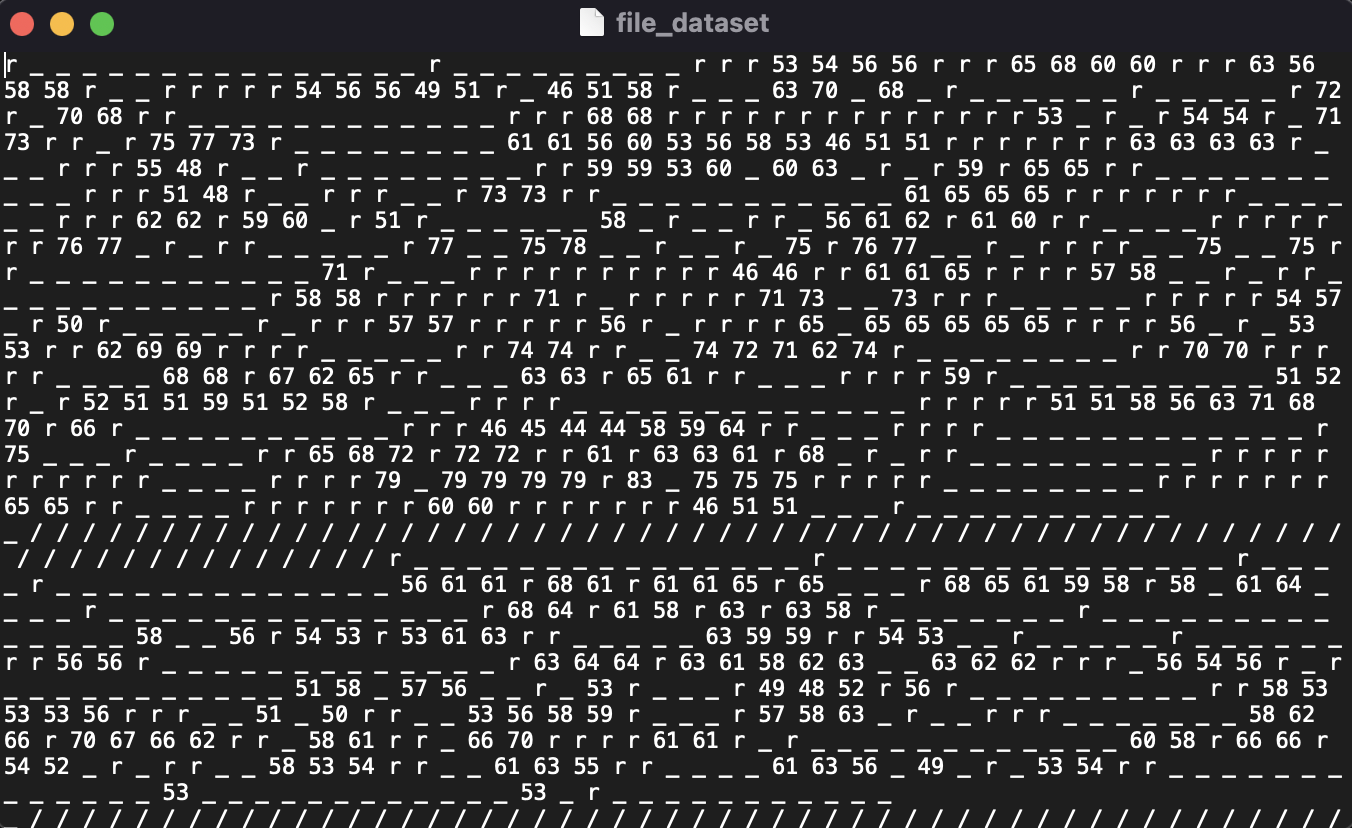

As can be seen in the picture above, all the encoded songs are now together in one big file. With a delimiter of 64 /'s between them to secure a boundary between the songs.<br><br>
But... the problem with this is, the model that I will be working with is not capable of reading strings. It can only read numbers.<br><br>
So what needs to happen: I need to create a mapping between all the symbols that I got and turn them into integers.<br>
<i> "Mapping: an operation that associates each element of a given set (the domain) with one or more elements of a second set (the range)."</i>

To achieve this, I will first count all the symbols there are and then put it into a json file. A json file is needed because it is a handy form to load during the training process that will come after this

In [17]:
import json

# the json file it will go into
mapping_path = "mapping.json"

def create_mapping(songs, mapping_path):
    
    # I will make a dictionary so each note and symbol will have its own 'row'. So, map notes to integers
    mappings = {}
    
    # first, I will split the song in its components, so all the same notes and r and _ together
    songs = songs.split()
    
    # then put those together in a list format
    vocabulary = list(set(songs))
    
    # when printing the vocabulary, I had these weird things between them, not sure where it came from, but I
    # removed them
    vocabulary.remove('\x00\x00\x00\x00\x00\x00\x01@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x10')
    vocabulary.remove('\x00\x00\x00\x01\x00\x00\x00@\x00\x00\x00\x01\x00\x00\x00€\x00\x00\x00\x01\x00\x00\x01\x00\x00\x00\x00\x01\x00\x00\x02\x00\x00\x00\x00\x01\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x10\x00\x00\x00\x00\x01\x00\x00')
    vocabulary.remove('\x00\x00\x00E\x00\x00\x00%\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x04DSDB\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00`\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00€\x00\x00\x00\x01\x00\x00\x01\x00\x00\x00\x00\x01\x00\x00\x02\x00\x00\x00\x00\x01\x00\x00\x04\x00\x00\x00\x00\x02\x00\x00\x08\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00')
    vocabulary.remove('\x00\x00\x00\x00\x01\x00\x00@\x00\x00\x00\x00\x01\x00\x00€\x00\x00\x00\x00\x01\x00\x01\x00\x00\x00\x00\x00\x01\x00\x02\x00\x00\x00\x00\x00\x01\x00\x04\x00\x00\x00\x00\x00\x01\x00\x08\x00\x00\x00\x00\x00\x01\x00\x10\x00\x00\x00\x00\x00\x01\x00')
    vocabulary.remove('\x00\x00\x00\x01Bud1\x00\x00\x10\x00\x00\x00\x08\x00\x00\x00\x10\x00\x00\x00\x00%\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x08')
    vocabulary.remove('\x00\x00\x00\x00\x00\x01\x00@\x00\x00\x00\x00\x00\x01\x00€\x00\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x01\x02\x00\x00\x00\x00\x00\x00\x01\x04\x00\x00\x00\x00\x00\x00\x01\x08\x00\x00\x00\x00\x00\x00\x01\x10\x00\x00\x00\x00\x00\x00\x01')
    vocabulary.remove('\x00\x00\x00\x00\x00\x00\x01@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')
    vocabulary.remove('\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00')
    
    # creating of the mapping
    # the put 2+2 together
    for i, symbol in enumerate(vocabulary):
        
        mappings[symbol] = i  
        
    print(vocabulary)
    
    # save vocabulary to the json file mentioned above
    
    with open(mapping_path, "w") as fp:
        
        # indent is to make the json file more friendly to read
        json.dump(mappings, fp, indent=4)
             
# source:
# https://www.youtube.com/watch?v=FLr0r-QhqH0&list=PL-wATfeyAMNr0KMutwtbeDCmpwvtul-Xz

In [18]:
create_mapping(songs, mapping_path)

['81', '83', '59', '70', '61', '69', '79', '54', '50', '65', '71', '58', '74', '62', '72', '85', '90', '66', '55', '87', '77', '52', '48', '89', '45', '75', '63', '86', '49', '51', '56', '73', '76', '68', 'r', '57', '67', '88', '64', '60', '78', '80', '91', '47', '84', '44', '46', '/', '82', '_', '53']


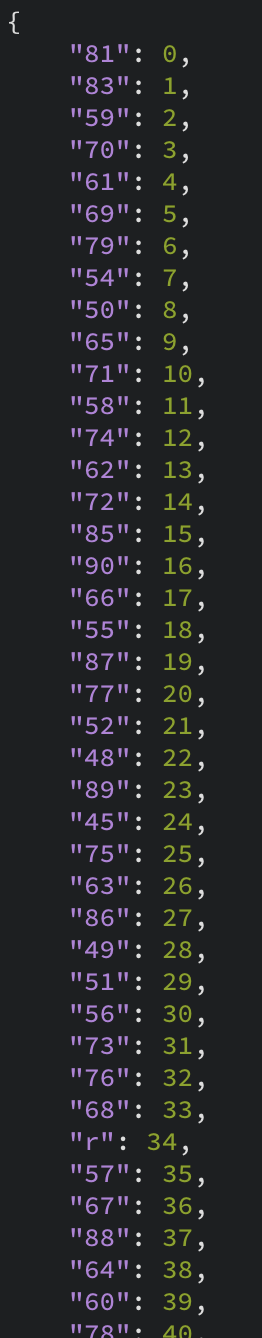

As can be seen, left are all the different symbols (notes, rest, space, break) that the songs have. And now, all of these symbols are mapped to integers. So for example, note 81 is mapped to integer 0. And a note that is a rest is mapped to integer 34. And so on it goes all the way to row 50. This is handy to have when creating sequences.<br><br>

Next, I am going to take the songs variable from above, that contains the one long string, and convert them into integers that are related from the json file. So basically, make the integers mapping values for the notes. Like a lookup table

In [22]:
def convert_songs_to_int(songs):
    
    int_songs = []

    # loading the json file mapping
    # fp means reading mode
    with open(mapping_path, "r") as fp:
        mappings = json.load(fp)

    # splits a string using empty spaces and creates a list from items
    # in the string
    songs = songs.split()

    # looping through all the symbols in the dataset
    for symbol in songs:
        
        # so, taking the mapping dictionary, and then looking up the value
        # corresponding to the symbol
        try:
            int_songs.append(mappings[symbol])
        # got an annoying error here that I could not find the answer for for multiple hours, so I decided on
        # a pass if it occured
        except KeyError:
            pass
        
        
    return int_songs

# source:
# https://www.youtube.com/watch?v=FLr0r-QhqH0&list=PL-wATfeyAMNr0KMutwtbeDCmpwvtul-Xz
# https://github.com/Skuldur/Classical-Piano-Composer/blob/master/lstm.py

In [23]:
convert_songs_to_int(songs)

[34,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 34,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 34,
 34,
 34,
 50,
 7,
 30,
 30,
 34,
 34,
 34,
 9,
 33,
 39,
 39,
 34,
 34,
 34,
 26,
 30,
 11,
 11,
 34,
 49,
 49,
 34,
 34,
 34,
 34,
 34,
 7,
 30,
 30,
 28,
 29,
 34,
 49,
 46,
 29,
 11,
 34,
 49,
 49,
 49,
 26,
 3,
 49,
 33,
 49,
 34,
 49,
 49,
 49,
 49,
 49,
 49,
 34,
 49,
 49,
 49,
 49,
 49,
 34,
 14,
 34,
 49,
 3,
 33,
 34,
 34,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 34,
 34,
 34,
 33,
 33,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 50,
 49,
 34,
 49,
 34,
 7,
 7,
 34,
 49,
 10,
 31,
 34,
 34,
 49,
 34,
 25,
 20,
 31,
 34,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 4,
 4,
 30,
 39,
 50,
 30,
 11,
 50,
 46,
 29,
 29,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 26,
 26,
 26,
 26,
 34,
 49,
 49,
 49,
 34,
 34,
 34,
 18,
 22,
 34,
 49,
 49,
 34,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 34,
 34,
 2,
 2,
 50,
 39,
 

So now the songs are converted to a list of integers.<br><br>

To give an example of what happened:

When looking at the first song in 'file dataset', the songs starts like:<br><br>
[r _ _ _ _ _ _ _ _ _ _ _ r _ _ _ _ _ r r r 53 54 ...]<br><br>

Then, I created a mapping between each symbol and a number. After that, I converted the songs [r _ _ ...] to the mapping created. So now, the beginning of the first song looks like this:<br><br>

[ 34 49 49 49 49 49 49 49 49 49 49 34 49 49 49 49 49 34 34 34 50 7 ...]<br><br>

integer 34 now stands for the r symbol, integer 49 now stands for the _ symbol and integer 50 now stands for the note 53<br><br>

So now that every symbol has become an int, the model can process it

Preprocessing is now done! Now I will be generating training sequences. Sequences are used for training the LSTM model. And sequences are basically subsets of the music data that have been gathered. So, the sequences will all be made out of integers. And these sequence are going to be fed to the network, the LSTM model, to train and then generate new predicted notes upon notes

In [26]:
# So I am making a function to create input and output data samples for training
# Each sample is a sequence

import tensorflow.keras as keras
import numpy as np

# again the sequence_length is 64, with a quantisation at 16th notes, 64 notes equates to 4 bars,
# what most songs are made of 4/4
def generate_training_sequences(sequence_length):
    
    # loading the songs and converted integers songs
    songs = load("file_dataset")

    int_songs = convert_songs_to_int(songs)
    
    # fixed length sequences / subsets of our input dataset
    inputs = []
    # targets are going to be the value of the item that comes just after
    # each sequence
    targets = []
    
    # To give an example of inputs and targets:
    # If our sequence data is [50, 51, 52, 54 ....]
    # Then inputs  would for example take [50, 51] and the target
    # would be [52]. the item that comes just after the input
    # sequence. This can be repeated. So input will be [51, 52] and
    # then target would be [53]. This will continue until the end
    # of the dataset. It is basically asking the network to predict
    # the next item in the dataset, the melody.
    
    # Now I am going to generate the training sequences
    # with 64 time steps for each training sampl
    # 100 symbol, 64 sl, 100 - 64 = 36 sequences
    
    num_sequences = len(int_songs) - sequence_length
    
    for i in range(num_sequences):
        
        inputs.append(int_songs[i:i+sequence_length])
        
        targets.append(int_songs[i+sequence_length])
    
    # one-hot encode the sequences and return
    
    vocabulary_size = len(set(int_songs))
    
    inputs = keras.utils.to_categorical(inputs, num_classes=vocabulary_size)
    
    targets = np.array(targets)
    
    return inputs, targets

# source:
# https://github.com/alexissa32/DataScienceMusic/blob/master/1LSTMAtt1LSTMLayer-fulldataset-results/.ipynb_checkpoints/DataScienceMusic-checkpoint.ipynb
# https://github.com/jordan-bird/Keras-LSTM-Music-Generator/blob/master/train.py

In [27]:
inputs, targets = generate_training_sequences(sequence_length)

print(inputs) # duration
print(targets) #notes

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  ...
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[11 34 49 

What is being seen now is:<br><br>
I have for example an input of a sequence: [0, 1, 2]. The numbers stand for the values that they can take. Now, the function made them transform into [ [ [1, 0, 0 ] [0, 1, 0] [0, 0, 1] ]. It uses a number of items which is equal to the vocabulary size of our dataset. So for the example here, 1+2 = 3, so 1+1+1 is also 3.<br><br>
<i>"a one-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value."</i><br>https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/<br><br> As for targets [11, 34, 49..], we see the value that comes after each sequence<br><br>
<b>Why was this important to do? </b><br>Because it is the easiest way I can deal with the categorical data and the model.<br>

<br>With the making of inputs and targets, I can easily put them into the LSTM model now! So now I am going to create the structure of the neural network

In [28]:
# keras is a library that helps with developing and evaluating deep learning models
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Activation

# the created inputs are used together with the notes
def create_network(inputs, notes_vocab):
    
    # here the structure building begins
    model = Sequential()
    
    # the first input layer receives two inputs
    # the higher the number, the more params will be used, the longer the wait,
    # the better trained model
    model.add(LSTM(
        64,
        input_shape=(inputs.shape[1], inputs.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    
    # Keras is an open source library that has multiple layers.
    # Each layer is fed with input information, then processed, than outputted
    model.add(LSTM(64, return_sequences=True, recurrent_dropout=0.3,))
    model.add(LSTM(64))
    model.add(BatchNorm())
    
    # A dropout layer: "for reducing over-fitting in neural network models"
    # https://machinelearningknowledge.ai/different-types-of-keras-layers-explained-for-beginners/
    model.add(Dropout(0.3))
    
    # A dense layer: "a deeply connected layer in the neural 
    # network where each of the neurons of the dense layers 
    # receives input from all neurons of the previous layer."
    # https://machinelearningknowledge.ai/different-types-of-keras-layers-explained-for-beginners/
    model.add(Dense(32))
    
    # Activation layer
    # "ReLu Layer in Keras is used for applying the rectified linear unit activation function"
    # https://keras.io/api/layers/activations/
    model.add(Activation('relu'))
    
    # Batchnorm
    # Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1
    # https://keras.io/api/layers/normalization_layers/batch_normalization/
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(notes_vocab))
    
    # Softmax
    # Softmax converts a vector of values to a probability distribution
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001))

    # Load the weights to each node
    #model.load_weights('weights.hdf5')
    
    model.summary()

    return model

# I have played around with multiple different layers. At first I wanted
# to only put three or four Keras layers in them (LSTM, Dense, Activation softmax), 
# but they gave weird errors. So I looked at how others did their music modeling 
# layers online and learned from that

# source:
# https://github.com/Skuldur/Classical-Piano-Composer/blob/master/predict.py
# https://www.tensorflow.org/tutorials/audio/music_generation
# https://github.com/alexissa32/DataScienceMusic/blob/master/1LSTMAtt1LSTMLayer-fulldataset-results/.ipynb_checkpoints/DataScienceMusic-checkpoint.ipynb

In [29]:
from keras.layers import BatchNormalization as BatchNorm

notes_vocab = len(set(notes))

model = create_network(inputs, notes_vocab)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64, 64)            29696     
                                                                 
 lstm_1 (LSTM)               (None, 64, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                        

As a result, this is the LSTM model that I build.<br>
It goes through multiple layers to finetune the results

In [30]:
model.summary()

# now i will train the inputs and targets into the created model, validation_split
# will help with evaluating the loss and accuracy of the model, epochs
# stands for how many times I want it to ran through. And because my laptop
# is not the fastest, I can't put it extremely high. Batch_size already
# mentioned above

# also, i put the model into the variable "history", as that will help with visualising
# the accuracy and loss later on
history = model.fit(inputs, targets, validation_split = 0.1, epochs=50, batch_size=64)

# then save the model outcome informaton in a "Hierarchical Data Format"
model.save("trainedmodel.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64, 64)            29696     
                                                                 
 lstm_1 (LSTM)               (None, 64, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                        

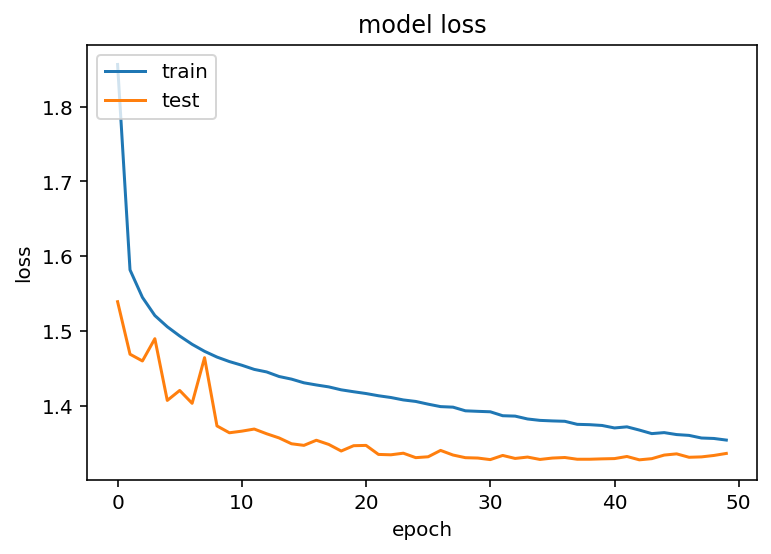

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# source:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

Loss shows a number indicating how bad the model's prediction was on a single example. Since I have picked the loss function "sparse categorical crossentropy", it will show: "Computes the crossentropy loss between the labels and predictions." https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class<br>
With also: "loss is the error evaluated during training a model, val_loss is the error during validation." https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/62261

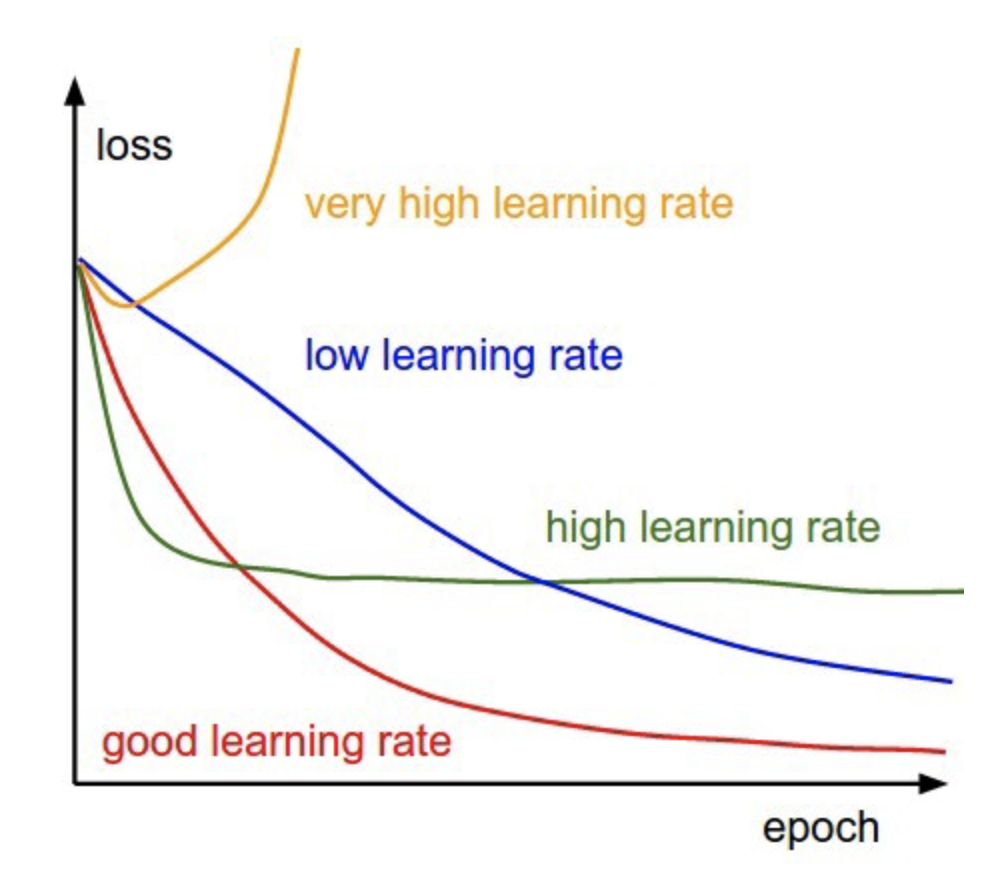

As can be seen, by the very big image, my model had a little trouble in the beginning, but fortunately overall it had a good learning rate. Which means that with each epoch the model became better <br>
https://towardsdatascience.com/useful-plots-to-diagnose-your-neural-network-521907fa2f45

Now that songs have been actually generated by the model, the last step comes. Generating the melodies and sampling the output of the neural network

In [32]:
# I will make a 'wrapper' class of some sorts, that will get around
# the model and help generate jazz songs and also convert them into MIDI's
 
class MelodyGenerator:

    # acquiring the .h5, the results of the training model
    def __init__(self, model_path="trainedmodel.h5"):

        self.model_path = model_path
        self.model = keras.models.load_model(model_path)

        with open("mapping.json", "r") as fp:
            self._mappings = json.load(fp)

        self._start_symbols = ["/"] * sequence_length

    def generate_melody(self, seed, num_steps, max_sequence_length, temperature):

        # create seed with start symbols. Give a starting point to the song, and then
        # the model can finish it. Ask the network to continue the melody
        seed = seed.split()
        melody = seed
        seed = self._start_symbols + seed

        # map seed to int, to make readable
        seed = [self._mappings[symbol] for symbol in seed]

        for _ in range(num_steps):

            # limit the seed to max_sequence_length
            seed = seed[-max_sequence_length:]

            # one-hot encode the seed
            onehot_seed = keras.utils.to_categorical(seed, num_classes=len(self._mappings))
            onehot_seed = onehot_seed[np.newaxis, ...]

            # make a prediction
            probabilities = self.model.predict(onehot_seed)[0]
            # [0.1, 0.2, 0.1, 0.6] -> 1
            output_int = self._sample_with_temperature(probabilities, temperature)

            # update seed
            seed.append(output_int)

            # map int to the encoding
            output_symbol = [k for k, v in self._mappings.items() if v == output_int][0]

            # check whether it is at the end of the melody
            if output_symbol == "/":
                break

            # update melody
            melody.append(output_symbol)

        return melody


    # sampling a value and index out ot the probabilty from above
    def _sample_with_temperature(self, probabilites, temperature):

        predictions = np.log(probabilites) / temperature
        probabilites = np.exp(predictions) / np.sum(np.exp(predictions))

        # [0, 1, 2, 3]
        choices = range(len(probabilites)) 
        index = np.random.choice(choices, p=probabilites)

        return index
    
    # converts a melody into a midi file with 0.25 durations
    def save_melody(self, melody, step_duration=0.25, format="midi", file_name="mel.mid"):

        # create a music21 stream
        stream = m21.stream.Stream()

        start_symbol = None
        step_counter = 1

        # parse all the symbols in the melody and create note/rest objects
        for i, symbol in enumerate(melody):

            # handle case in which we have a note/rest
            if symbol != "_" or i + 1 == len(melody):

                # ensure we're dealing with note/rest beyond the first one
                if start_symbol is not None:

                    quarter_length_duration = step_duration * step_counter # 0.25 * 4 = 1

                    # handle rest
                    if start_symbol == "r":
                        m21_event = m21.note.Rest(quarterLength=quarter_length_duration)

                    # handle note
                    else:
                        m21_event = m21.note.Note(int(start_symbol), quarterLength=quarter_length_duration)

                    stream.append(m21_event)

                    # reset the step counter
                    step_counter = 1

                start_symbol = symbol

            # handle case if there is a "_"
            else:
                step_counter += 1

        # write the m21 stream to a midi file
        stream.write(format, file_name)

        
# source:
# very big help for this part from:
# https://www.youtube.com/watch?v=FLr0r-QhqH0&list=PL-wATfeyAMNr0KMutwtbeDCmpwvtul-Xz

After helping the model with predictions and giving it a head start with a seed, let's activate it

<hr>

## Evaluate

In [33]:
mg = MelodyGenerator()
# i picked the starting seed from a random song out of dataset that did not start with 
# a lot of r's and _'s
seed = "r _ _ 58 _ r 60 _ 62 _ 64 _ 65 _ r 60 _ _ _ _ _"
# 500 stands for the max steps I am giving the network, 
# if the network decides the song ends on 367, then it will not continue on to 500
# 0.7 is the temperature from above
melody = mg.generate_melody(seed, 500, sequence_length, 0.7)
print(melody)
mg.save_melody(melody)

['r', '_', '_', '58', '_', 'r', '60', '_', '62', '_', '64', '_', '65', '_', 'r', '60', '_', '_', '_', '_', '_', '_', 'r', 'r', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'r', '_', 'r', '_', '_', '_', '_', '_', '_', '_', '_', '_', '65', '_', 'r', '_', '_', '_', '61', '_', 'r', '_', '65', '_', 'r', '_', '65', 'r', '_', '_', '_', '_', '_', '_', '63', 'r', '63', '_', '63', '_', 'r', '_', 'r', '_', '_', '_', '_', '_', '61', '_', '61', '62', '_', '65', '_', 'r', '_', 'r', '_', '_', '_', '_', '_', '_', '_', '_', '_', '63', '_', 'r', '_', '_', '65', '_', '63', '_', '_', '62', 'r', '58', 'r', '61', 'r', '63', '63', 'r', 'r', '_', '_', '_', '_', 'r', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'r', 'r', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '58', '_', '61', 'r', '65', '70', '68', 'r', '_', 'r', '69', '68', 'r', 'r', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'r', '65', '67', 'r', '_', '_', '_', '_', '_', '_', '_', '_', 

When looking at the results from above, the model has definitely picked up some fun notes, but also a lot of durations.<br>
I am not too surprised at those spaces, because many jazz songs started with a lot and long sets of 'r' and '_'. 

Furthermore, I think the problem might also lie in the difficulty of the jazz songs, because were the notes more even and durations more the same (because from exploratory data analysis it could be seen that there was still a vast variety in them), I believe the model would have picked up more seen notes.<br><br>
<i>The melody stops after the last note, 58. So all the 'r' and '_' after that last note can be thought out</i>

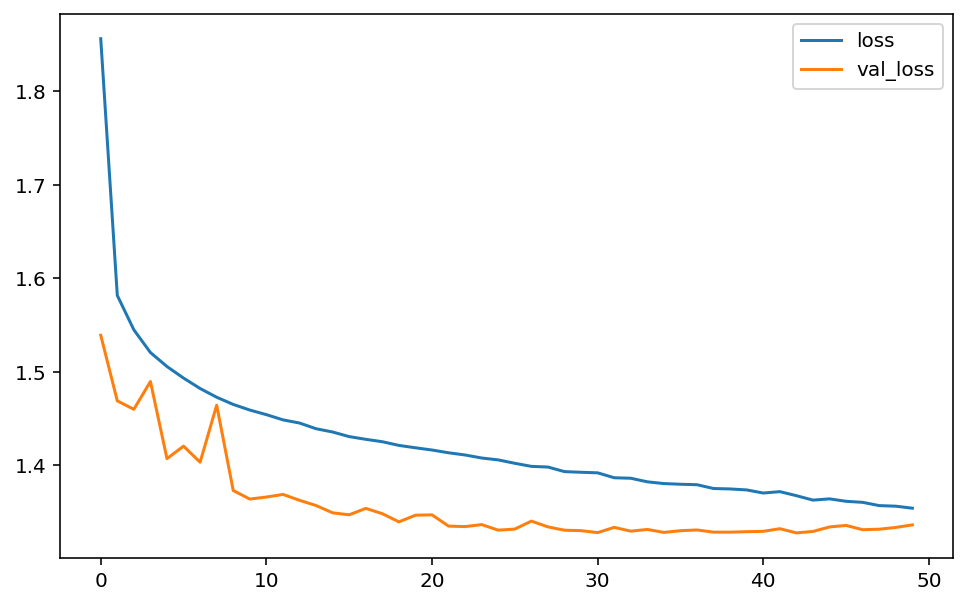

In [36]:
# overall picture
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Again getting the loss plot, because I want to look at it with a bigger frame. <br>
The loss function helps evaluate the perfomance of the model, and as shown in the big example from above, the model succeeded in achieving a good learning rate<br>

It can also be seen that after around 35 epochs the line became less sturdy. I believe the model in the end gained a little bit more uncertainty about what it was training.<br>Nonetheless, it also looks like the biggest spring is around 42 epochs, so the model did neatly recover on its own, which is good<br>

In the end I decided to go with 50 epochs, which took around 6 hours. But before 50 I also did an experiment with 10.

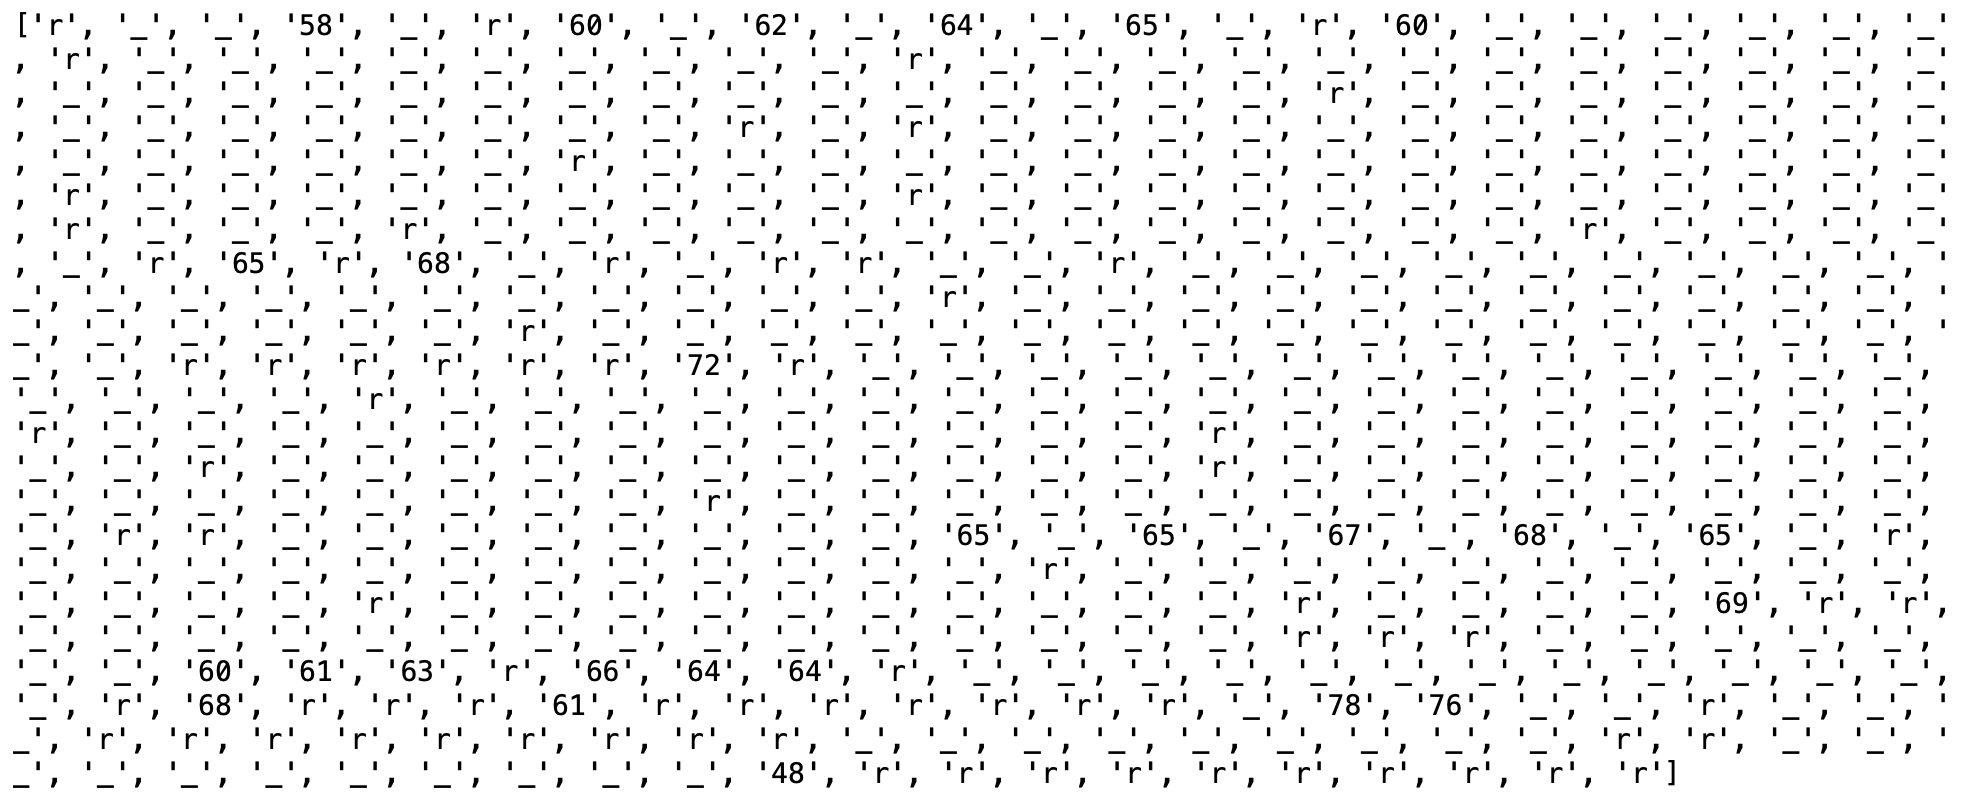

There is a big difference to be seen in the 50 epoch and 10. In 10 the notes are a lot more spread out and also fewer in numbers. So this does confirm that if I would give the model more data to train with (64 -> 128) and perhaps more epochs (50 -> 100), then more put together jazz songs will emerge. So the model seems to train accurately and the code has no errors.

<br>

But ofcourse the most important result is the midi song it created:

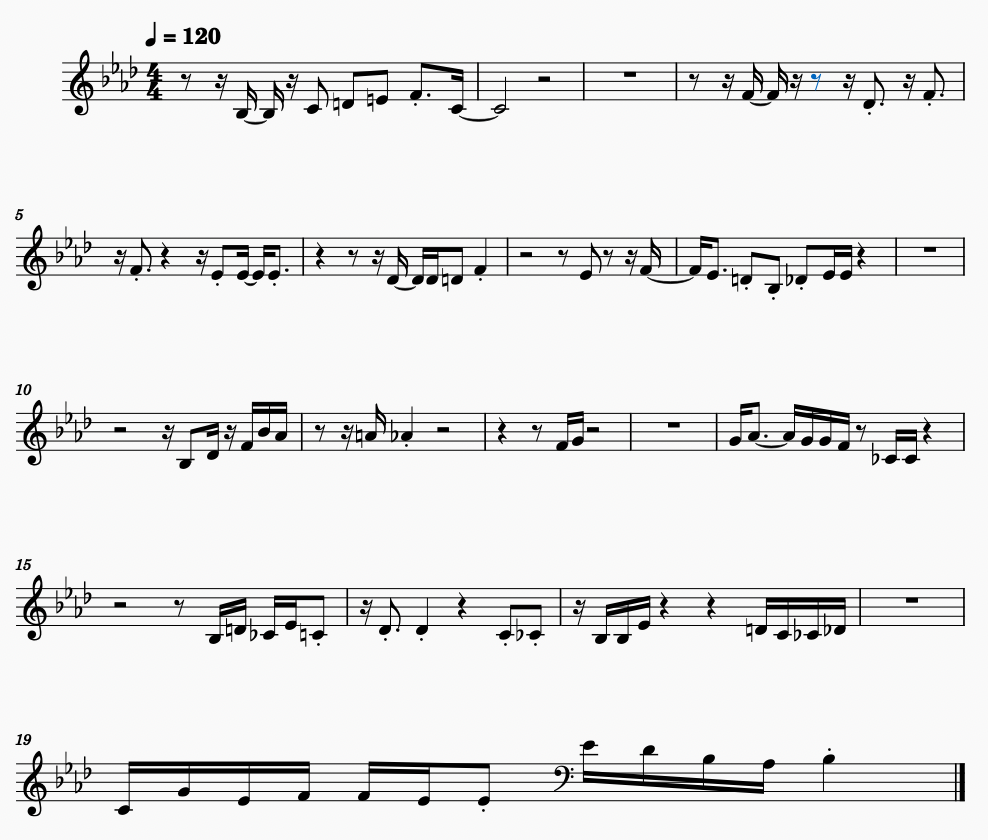

The music sheet looks nice and full! But unfortunately it has some awkward spaces of rest in between the notes, which already was present to be seen in the integers from above<br><br>
But, the notes themselves when played sound really fun and I do hear a jazz undertone from them, so that is a success! I wonder how they would sound together without the rests.<br><br>
I also like how the song decided to end, that was the only real smooth line<br><br>

In the end, I do consider the challenge I made a success! I made a song with a generative deep learning network that succesfully has jazz undertones. I think if I would try this again, I would pick out easier music sheets, reduce the rests and give my model more data to train with, so I could get even better results. 

<i>The midi file should also be present in my Github folder</i>